In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
import shutil
import os
import random
import cv2

2024-10-04 15:15:50.246948: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 15:15:50.333551: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 15:15:50.432724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 15:15:50.512606: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 15:15:50.533871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 15:15:50.672447: I tensorflow/core/platform/cpu_feature_gu

In [18]:
def copy_images(src_directory, dst_directory):
    # Check if the destination directory exists, if not, create it
    if not os.path.exists(dst_directory):
        os.makedirs(dst_directory)
    
    # Walk through the source directory
    for root, dirs, files in os.walk(src_directory):
        for file in files:
            # Build the path to the source file
            src_file = os.path.join(root, file)
            # Build the destination path while maintaining the directory structure
            dst_file = os.path.join(dst_directory, os.path.relpath(src_file, src_directory))
            # Create any directories needed in the destination path
            os.makedirs(os.path.dirname(dst_file), exist_ok=True)
            # Copy the file from source to destination
            shutil.copy(src_file, dst_file)
src_dir = '../data/landing'
dst_dir = '../data/curated'            
copy_images(src_dir, dst_dir)

In [35]:
train_dir = '../data/curated/train'
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size = (299, 299),
    batch_size = 32,
    label_mode = 'categorical'
)

val_dir = '../data/curated/valid'
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size = (299,299),
    batch_size = 32,
    label_mode = 'categorical'
)

test_dir = '../data/curated/test'
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size = (299,299),
    batch_size = 32,
    label_mode = 'categorical'
)


Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.


In [13]:
class_counts = Counter()
for images, labels in train_dataset:
    # Convert one-hot encoded labels to class indices
    class_indices = np.argmax(labels.numpy(), axis=1)
    class_counts.update(class_indices)

# Print the counts for each class
print("Number of images per class:")
for class_idx, count in class_counts.items():
    print(f"Class {class_idx}: {count} images")

Number of images per class:
Class 2: 148 images
Class 3: 155 images
Class 0: 195 images
Class 1: 115 images


In [14]:

def flip_left_right(image, label):
    image = tf.image.flip_left_right(image)
# Define a function to flip an image left-right
def flip_left_right(image, label):
    image = tf.image.flip_left_right(image)
    return image, label

# Apply the flip_left_right function to each image in the dataset
flipped_dataset = train_dataset.map(flip_left_right) 

# Concatenate with train dataset
train_dataset = train_dataset.concatenate(flipped_dataset)

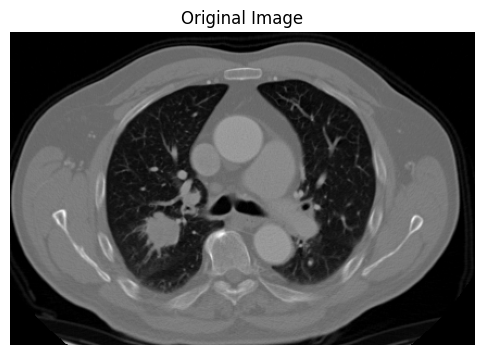

In [15]:
''' Check random image in the new train data'''

# Randomly select an image from the training set
class_name = random.choice(os.listdir(train_dir))
class_path = os.path.join(train_dir, class_name)
image_name = random.choice(os.listdir(class_path))
image_path = os.path.join(class_path, image_name)

# Load the image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Plot the original image
plt.figure(figsize=(6, 6))

# Display the original image
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')  # Hide axis for cleaner display

# Show the plot
plt.show()

In [16]:
# Initialize a counter
image_count = 0

# Iterate over the dataset and count images
for images, labels in train_dataset:
    image_count += images.shape[0]  # Add the batch size (number of images in this batch)

print(f"Total number of images in the training dataset: {image_count}")


Total number of images in the training dataset: 1226


2024-10-04 15:19:46.632929: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
''' preprocess '''

'''Normalization'''
# Create normalization layer that rescale pixel values from [0,255] to [0,1]
normalization_layer = layers.Rescaling(1./255)


# Apply the normalization layer to the dataset
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

'''Augumentation (just do it slightly, as the medical ct is sensitive, hence, the augmentations should preserve the medical features and the structural integrity of the images)'''


# Data augmentation (minimal augmentation)
data_augmentation = tf.keras.Sequential(
    [
        # Randomly adjust the contrast of the image. 
        layers.RandomContrast(factor=(0.9, 1.1)),
        # Randomly translate (shift) the image along the height and width.
        layers.RandomTranslation(height_factor=0.1, width_factor=0.05),
        #Rotate the image by 5%
        layers.RandomRotation(0.05)
    ]
)

# Apply the augmentation to the training dataset and validation dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
validation_dataset_dataset = validation_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [18]:
''' Build CNN model'''
# Define the CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    layers.BatchNormalization(), # Added Batch Normalization
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(512, (3, 3), activation='relu'),  # Added a new conv layer
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Add dropout to prevent overfitting
    layers.Dense(4, activation='softmax')  # Change 3 to the number of your classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'binary_crossentropy' for 2 classes
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 248, 248, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 122, 122, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 59, 59, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,128,708 (31.01 MB)

 Trainable params: 8,126,724 (31.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [19]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs = 10   # Adjust the number of epochs based on your data
)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.3865 - loss: 9.5013 - val_accuracy: 0.1806 - val_loss: 9.7835
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.4105 - loss: 7.5601 - val_accuracy: 0.3194 - val_loss: 5.3308
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.4442 - loss: 4.2914 - val_accuracy: 0.3194 - val_loss: 1.4252
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.4864 - loss: 2.4870 - val_accuracy: 0.2222 - val_loss: 4.0339
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.4591 - loss: 2.0321 - val_accuracy: 0.4167 - val_loss: 1.6020
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.4867 - loss: 1.4305 - val_accuracy: 0.3194 - val_loss: 1.3743
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.4860 - loss: 1.1623 - val_accuracy: 0.3750 - val_loss: 1.2425
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.5086 - loss: 1.1315 - val_accuracy: 0.3611 - v

In [20]:
''' Evaluate the model'''
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {val_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - accuracy: 0.3641 - loss: 1.2649
Validation Accuracy: 0.3611111044883728


In [21]:
''' Run this block to get the prediction by the model, each will give different prediction each time'''
# Get predictions on the validation set
predictions = model.predict(validation_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from the validation dataset
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
true_classes = np.argmax(true_labels, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step


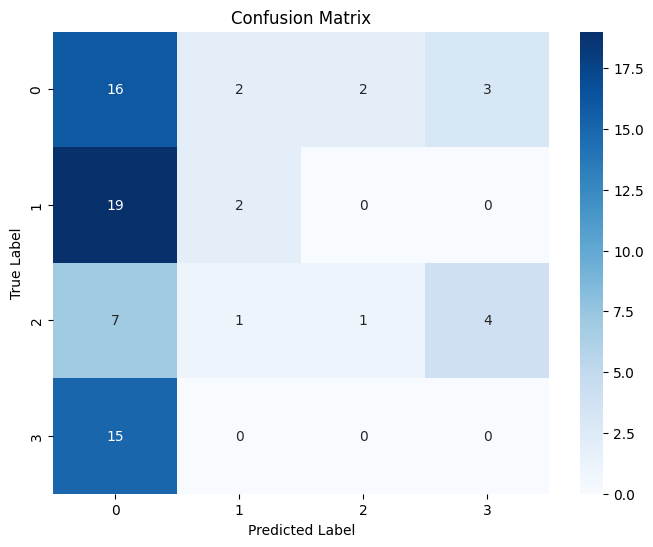

In [22]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)


# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [24]:
# Compute accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

# Compute precision (macro-averaged across all classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
print(f"Precision (macro): {precision:.4f}")

# Compute recall (macro-averaged across all classes)
recall = recall_score(true_classes, predicted_classes, average='macro')
print(f"Recall (macro): {recall:.4f}")

# Compute F1-score (macro-averaged across all classes)
f1 = f1_score(true_classes, predicted_classes, average='macro')
print(f"F1-Score (macro): {f1:.4f}")

Accuracy: 0.2639
Precision (macro): 0.2535
Recall (macro): 0.2170
F1-Score (macro): 0.1697


#### Try using a pre-trained model InceptionV3 to compare performance

In [23]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [26]:
# Load the InceptionV3 model, pretrained on ImageNet, without the top dense layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers so they are not trained
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 229s 3us/step


In [27]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global pooling layer instead of Flatten
    layers.Dense(512, activation='relu'),  # Add a dense layer
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(4, activation='softmax')  # Output layer for 4 classes (adenocarcinoma, etc.)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Create ImageDataGenerators for loading and augmenting the images
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=40,  # Data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Validation data is only rescaled

# Load the images from the directory and resize them to 299x299
train_generator = train_datagen.flow_from_directory(
    '../data/curated/train',  # Path to training data
    target_size=(299, 299),  # Resize to match InceptionV3 input size
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    '../data/curated/valid',  # Path to validation data
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    '../data/curated/test',  # Path to validation data
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [29]:
# Learning rate scheduler to reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Early stopping to stop training if validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [30]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

/home/obli/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.2669 - loss: 2.1080 - val_accuracy: 0.5000 - val_loss: 1.0205 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4487 - loss: 1.1668 - val_accuracy: 0.4861 - val_loss: 0.9905 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5162 - loss: 0.9901 - val_accuracy: 0.5000 - val_loss: 0.9968 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5661 - loss: 0.9254 - val_accuracy: 0.5000 - val_loss: 1.0871 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5725 - loss: 0.9099 - val_accuracy: 0.5556 - val_loss: 0.9327 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5706 - loss: 0.8963 - val_accuracy: 0.5417 - val_loss: 0.9714 - learning_rate: 0.0010
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6097 - loss: 0.8716 - val_accuracy: 

In [31]:
''' Evaluate the model'''
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {val_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 664ms/step - accuracy: 0.5256 - loss: 1.0357
Validation Accuracy: 0.5277777910232544


In [36]:
''' Run this block to get the prediction by the model, each will give different prediction each time'''
# Get predictions on the validation set
predictions = model.predict(validation_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from the validation dataset
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
true_classes = np.argmax(true_labels, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


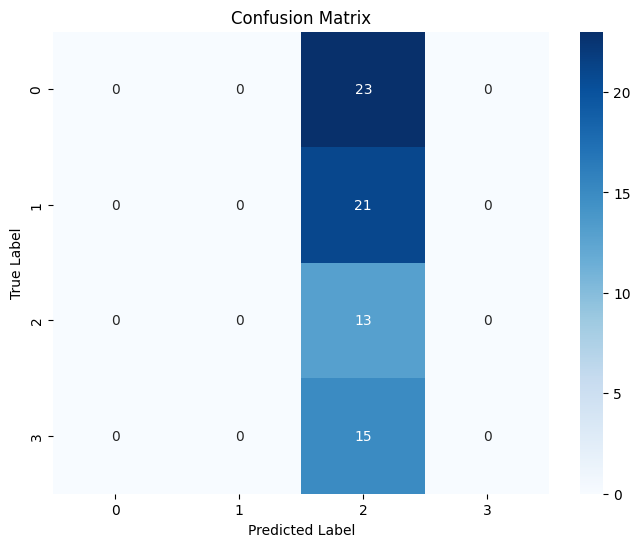

In [37]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)


# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()